# Analysis of filter circuit

This notebook analyses the filter in the circuit diagram below:

![Circuit Diagram of filter](assets/images/circuit.png)

Now onto our filter. See handwritten notes for complete derivation but the transfer function $H(s)$ is:

$$H(s) = \frac{u_{in}}{u_{out}} =  \frac{CLR \cdot s^2 + R}{CLR \cdot s^2 + Ls + R}$$

The minimum magnitude is:-22.691625447116405


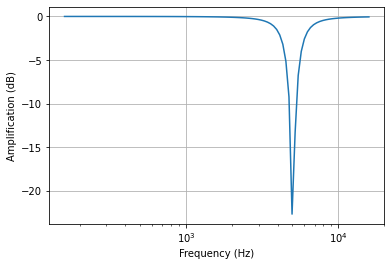

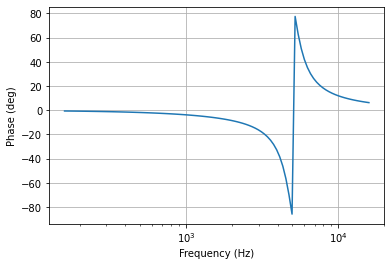

In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)

w, mag, phase = signal.bode(LTI)

print('The minimum magnitude is:' + str(min(mag)))

# Convert rad/s to Hz
f=w/(2*np.pi)

plt.figure()
plt.semilogx(f,mag)
#plt.hlines(-3,min(f),max(f),linestyles="dotted",colors='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplification (dB)')
plt.grid()
plt.figure()
plt.semilogx(f, phase)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (deg)')
plt.grid()
plt.show()



See handwritten note for expression for step response. The basics are that we use a convolution of the Heavyside function with the impulse response for our LTI-system. We don't know and don't need to know the impulse response, we use the Laplace Transform to find the laplace transform of the step response and then invert it to find the actual step response. 

1.1533698388510394
1.1510126756282806


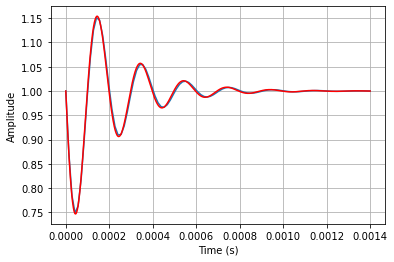

In [175]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)
tDataLTI, yDataLTI = signal.step(LTI)


a = - 1 / (2*R*C)
b = np.sqrt(np.abs(L-4*R ** 2 * C /(4* R **2 * C ** 2 * L)))
c = np.sqrt(np.abs(L ** 2 - 4 * R ** 2 * C * L))

calcTransfer = lambda t : 1 - 2*L / (c) * np.exp(t*a) * np.sin(b * t)
tInput = np.linspace(min(tDataLTI),max(tDataLTI),1000)

i = 10
print(calcTransfer(tDataLTI[i]))
print(yDataLTI[i])

plt.plot(tDataLTI, yDataLTI)
plt.plot(tInput, calcTransfer(tInput), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()